In [3]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

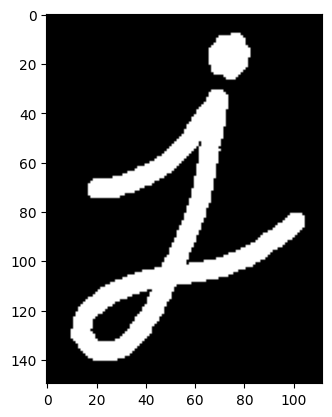

In [4]:
img = cv.imread('bw_text.png')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

greyscale_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
plt.subplot
plt.imshow(greyscale_img, cmap='grey')

The Canny algorithm consists of five sequential steps:

1. **Apply Gaussian Blur (Noise Reduction)**
2. **Compute Image Gradients (Edge Strength & Direction)**
3. **Non-Maximum Suppression (Thinning the Edges)**
4. **Double Thresholding (Edge Classification)**
5. **Edge Tracking by Hysteresis (Finalizing the Edges)**

In [5]:
def convolve(img, kernel): 
    #? 1. Get image and kernel shapes
    height, width = img.shape
    k_h, k_w = kernel.shape  # e.g., (3, 3)
    
    #? 2. Pad the image
    pad_h = k_h // 2  # e.g. 3 // 2 = 1 if k_h=3
    pad_w = k_w // 2
    new_height = height + 2*pad_h # add to 2 size horizontally    
    new_width = width + 2*pad_w  # add to 2 size vertically
    
    # Initialize padded image
    padded_img = np.zeros((new_height, new_width), dtype=img.dtype)
    padded_img[pad_h:pad_h+height, pad_w:pad_w+width] = img
    
    #? 3. Create output array
    # zeros_like: Return an array of zeros with the same shape and type as a given array
    filtered_img = np.zeros_like(img, dtype=np.float32)
    
    #? 4. Convolution-like operation
    for i in range(height): # rows
        for j in range(width): # cols
            # local region in padded image
            region = padded_img[i : i + k_h, j : j + k_w] # region_size == kernel_size
            
            # element-wise multiply and sum
            value = np.sum(region * kernel)
            
            # assign to output
            filtered_img[i, j] = value 
    
    return filtered_img

In [6]:
import numpy as np

def gaussian_kernel(k, sigma=1.0):
    """
        Creates a 2D Gaussian kernel array with size k x k and standard deviation sigma.
    """
    # Ensure k is odd
    assert k % 2 == 1, "Kernel size must be odd"
    
    # Coordinate grid (centered at 0,0)
    half = k // 2
    x, y = np.meshgrid(np.arange(-half, half+1), np.arange(-half, half+1))
    
    # Compute the 2D Gaussian
    g = (1.0 / (2.0 * np.pi * sigma**2)) * np.exp(- (x**2 + y**2) / (2.0 * sigma**2))
    
    # Normalize so the sum of all elements is 1
    g /= g.sum()
    return g


In [7]:
def gaussian_blur(img, k=5, sigma=1.0):
    """
    Blurs an image (grayscale or color) using a Gaussian kernel of size k x k
    and standard deviation sigma.
    """
    # 1. Create Gaussian kernel
    kernel = gaussian_kernel(k, sigma)
    
    return convolve(img, kernel)

## Gaussian Blur (Noise Reduction)

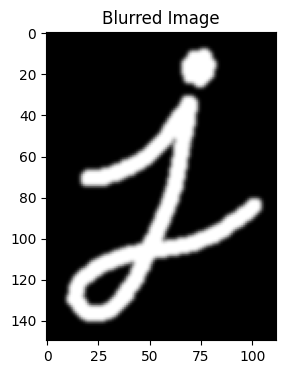

In [15]:
blur_image = gaussian_blur(greyscale_img)

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(blur_image, cmap='gray')
ax.set_title('Blurred Image')
plt.show()

## Compute Image Gradients (Edge Strength & Direction)

In [ ]:
def compute_gradients(img):
    """Compute gradient magnitude and direction using the Sobel operator."""
    # Define Sobel kernels for X and Y directions
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]], dtype=np.float32)
    sobel_y = np.array([[-1, -2, -1],
                        [ 0,  0,  0],
                        [ 1,  2,  1]], dtype=np.float32)
    
    # Compute gradients along X and Y using convolution
    Gx = cv.filter2D(img, cv.CV_32F, sobel_x)
    Gy = cv.filter2D(img, cv.CV_32F, sobel_y)
    
    # Gradient magnitude and angle (in degrees)
    magnitude = np.sqrt(Gx**2 + Gy**2)
    angle = np.arctan2(Gy, Gx) * 180 / np.pi  # convert to degrees

    # Make angles positive (0 to 180)
    angle[angle < 0] += 180
    
    return magnitude, angle

gradient_magitude: [[1.41421356 2.         1.41421356]
 [2.         0.         2.        ]
 [1.41421356 2.         1.41421356]]
gradient_direction: [[-2.35619449 -1.57079633 -0.78539816]
 [ 3.14159265  0.          0.        ]
 [ 2.35619449  1.57079633  0.78539816]]


## Non-Maximum Suppression (Edge Thinning)
At this stage, edges are still thick. We must thin them down to a single pixel width.

+ For each pixel:
    + Compare it with its two neighbors along the gradient direction.
    + Keep only the local maxima (strongest edges).
    + Suppress weaker edge pixels.

**Effect:** Reduces edge thickness and removes non-significant edges.